In [1]:
from fastai.text.all import *
from minGPT.mingpt.model import GPT, GPTConfig, GPT1Config
import torch
import os
import numpy as np

In [103]:
#Here the corpus is quite small so we can easily iterate through it but in reality we can preprocess the corpus
class Vocabulary:
    def __init__(self, folder_with_txt, song_separator="\n"):
        self.folder_with_txt = folder_with_txt
        self.song_separator = song_separator
        self.build_mappings()
        
    def build_mappings(self):
        corpus = ""
        for root, subdirs, files in os.walk(self.folder_with_txt):
            for f in files:
                final_path = os.path.join(root,f)
                with open(final_path, 'r') as f:
                    corpus = "".join([corpus, f.read().replace(self.song_separator, " ")])
                    
        self.unique_words = set(corpus.strip().split(" "))
        self.vocab_length = len(self.unique_words)
        self.int_to_word = {index : word for index,word in enumerate(self.unique_words)}
        self.word_to_int = {word: index for index,word in self.int_to_word.items()}
        
    def tokenize_song(self, song):
        return song.strip().split(" ")
    
    def numberalize_song(self, song):
        numberalized = []
        
        for token in self.tokenize_song(song):
            numberalized.append(self.word_to_int[token])
            
        return numberalized
    
    def numberalize_tokenized(self, tokenized):
        numberalized = []
        
        for token in tokenized:
            numberalized.append(self.word_to_int[token])
            
        return numberalized
            
    def numberlized_to_text(self, numberalized):
        song = []
        
        for token in numberalized:
            song.append(self.int_to_word[token])
            
        return " ".join(song)
            
    

In [3]:
#The transform object is the main building block of the fastai data pipelines
class SongTransform(Transform):
    def __init__(self, data, vocab : Vocabulary):
        self.vocab = vocab
        self.data = data
        self.n_sequences = len(self.data)
    
    def encodes(self, o):
        i = np.random.randint(0, self.n_sequences)
        return torch.tensor(self.data[i])
    
    def decodes(self, o):
        t = ' '.join([self.vocab.int_to_word[s.item()] for s in o])
        return TitledStr(t)

In [98]:
def merge_file(source, dest):
    unique_words = set()
    new_text = ""
    with open(source, "r") as f:
        text = f.read()
        token = ""
        for l in text:
            if l == " " or l == "\n":
                if ":" in token:
                    unique_words.add(token)
                    new_text += token + l
                    token = ""
                else:
                    token += ":"
            else:
                token += l

    with open(dest, "w") as f:
        f.write(new_text)
        
    return unique_words
    
        

In [100]:
train_unique = merge_file("../data/Nottingham_txt/train.txt", "../data/Nottingham_txt/train_merged.txt")
test_unique = merge_file("../data/Nottingham_txt/valid.txt", "../data/Nottingham_txt/valid_merged.txt")

In [104]:
unique_words = set.union(train_unique, test_unique)

In [105]:
len(unique_words)

612

In [106]:
def build_blocks(songs, block_size, vocab):
    blocks = []
    for song in songs:
        tokenized = song.split(" ")
        if block_size >= len(tokenized):
            continue
        for i in range(0, len(tokenized), block_size):
            if i + block_size >= len(tokenized):
                start = len(tokenized) - block_size
                blocks.append(vocab.numberalize_tokenized(tokenized[start:start+block_size]))
            else:
                blocks.append(vocab.numberalize_tokenized(tokenized[i:i+block_size]))
    return blocks

In [110]:
vocab = Vocabulary("../data/merged2/")  

In [111]:
vocab.vocab_length

612

In [25]:
#We must somehow divide it on the blocks of some size.
#I don't want to use strategy that we randomly sample from some moment of the song + block_size.
path = '../data/Nottingham_txt_merged/train_merged.txt'
with open(path, "r") as f:
    text = f.read().strip()
    songs = text.split("\n")
 
block_size = 128  
blocks = build_blocks(songs, block_size,vocab)

In [28]:
path = '../data/Nottingham_txt_merged/valid_merged.txt'
with open(path, "r") as f:
    text = f.read().strip()
    songs = text.split("\n")
 
block_size = 128  
blocks_valid = build_blocks(songs, block_size,vocab)

In [46]:
n_samples = len(blocks)
cut = int(n_samples*0.8)
splits = [list(range(cut)), list(range(n_samples))]

tls = TfmdLists(list(range(n_samples)), tfms=[SongTransform(blocks,vocab)], split_idx=0, dl_type=LMDataLoader, splits=splits)

In [47]:
show_at(tls.train, 0)

w:t16 n50:t31 n54:t31 n57:t31 n74:t7 w:t8 n74:t7 w:t8 n76:t7 w:t8 n74:t7 w:t8 n57:t31 n60:t31 n64:t31 n72:t7 w:t8 n71:t7 w:t8 n69:t15 w:t16 n57:t7 n60:t7 n64:t7 w:t8 n57:t23 n60:t23 n64:t23 n69:t7 w:t8 n68:t7 w:t8 n69:t7 w:t8 n71:t7 w:t8 n57:t31 n60:t31 n64:t31 n72:t7 w:t8 n71:t7 w:t8 n72:t7 w:t8 n74:t7 w:t8 n57:t31 n60:t31 n64:t31 n76:t7 w:t8 n75:t7 w:t8 n76:t7 w:t8 n77:t7 w:t8 n57:t31 n60:t31 n64:t31 n76:t31 w:t32 n50:t31 n53:t31 n57:t31 n74:t7 w:t8 n73:t7 w:t8 n74:t7 w:t8 n76:t7 w:t8 n64:t31 n69:t31 n72:t31 w:t8 n71:t7 w:t16 n74:t7 w:t8 n52:t31 n56:t31 n59:t31 n62:t31 n71:t7 w:t8 n70:t7 w:t8 n71:t7 w:t8 n72:t7 w:t8 n57:t31 n60:t31 n64:t31 n69:t7 w:t8 n71:t7 w:t8 n72:t15 w:t16 n50:t31 n54:t31 n57:t31 n69:t7 w:t8 n71:t7 w:t8 n72:t15 w:t16 n52:t31 n56:t31 n59:t31 n62:t31 n76:t7 w:t8 n74:t7 w:t8 n71:t7 w:t8 n72:t7 w:t8 n57:t31 n60:t31 n64:t31 n69:t31


In [48]:
bs = 32
dls = tls.dataloaders(bs=bs, seq_len=block_size)

In [49]:
type(dls)

fastai.data.core.DataLoaders

In [50]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0] # To get only the logits

In [51]:
mconf = GPTConfig(dls.song_transform.vocab.vocab_length, block_size, n_layer=6, n_head=8, n_embd=512)
model = GPT(mconf)

In [68]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), opt_func=partial(Adam, sqr_mom=0.95, wd=0.1), 
                cbs=[DropOutput], metrics=[perplexity]).to_fp16()

In [69]:
learn.path = Path(".")

SuggestedLRs(valley=0.00013182566908653826)

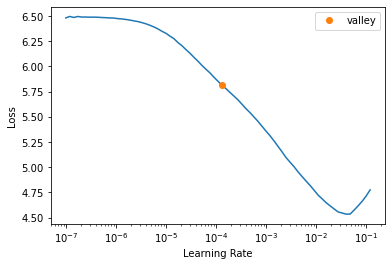

In [57]:
learn.lr_find()

In [75]:
learn.fit_one_cycle(5, 1e-4, cbs=[EarlyStoppingCallback(monitor='perplexity', comp=np.less, min_delta=0.01, patience=5), SaveModelCallback(monitor='perplexity', comp=np.less, min_delta=0.01)])    

epoch,train_loss,valid_loss,perplexity,time
0,1.546076,1.492319,4.447398,00:49
1,1.534400,1.469546,4.347263,00:49
2,1.525077,1.456397,4.290475,00:49
3,1.515217,1.458435,4.299225,00:49


Better model found at epoch 0 with perplexity value: 4.447397708892822.
Better model found at epoch 1 with perplexity value: 4.347262859344482.
Better model found at epoch 2 with perplexity value: 4.290474891662598.
No improvement since epoch 2: early stopping


In [76]:
from minGPT.mingpt.utils import sample

context = "n66:t3 w:t4 n64:t3 w:t4"
x = torch.tensor([vocab.numberalize_song(token) for token in context.split(" ")], dtype=torch.long).to(dls.device)
y = sample(model, x, 200, temperature=0.9, sample=True, top_k=5)[0]
completion = vocab.numberlized_to_text(y.cpu().numpy())
print(completion)

n66:t3 w:t4 n67:t3 w:t4 n67:t3 w:t4 n69:t3 w:t4 n67:t3 w:t4 n55:t31 n59:t31 n62:t31 n71:t3 w:t4 n69:t3 w:t4 n71:t3 w:t4 n67:t3 w:t4 n67:t3 w:t4 n69:t3 w:t4 n71:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n71:t3 w:t4 n57:t31 n60:t31 n64:t31 n69:t3 w:t8 n76:t3 w:t4 n78:t3 w:t4 n78:t3 w:t4 n74:t3 w:t4 n76:t3 w:t4 n76:t3 w:t4 n69:t3 w:t4 n50:t31 n54:t31 n57:t31 n60:t31 n74:t7 w:t8 n69:t7 w:t8 n69:t7 w:t8 n69:t7 w:t8 n71:t3 w:t4 n74:t3 w:t4 n71:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n55:t31 n59:t31 n62:t31 n71:t3 w:t4 n76:t3 w:t4 n79:t3 w:t4 n79:t3 w:t4 n79:t3 w:t4 n76:t3 w:t4 n74:t3 w:t4 n74:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n50:t31 n54:t31 n57:t31 n74:t7 w:t8 n78:t3 w:t4 n78:t3 w:t4 n78:t3 w:t4 n79:t3 w:t4 n74:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n57:t31 n61:t31 n64:t31 n67:t31 n76:t3 w:t4 n73:t3 w:t4 n74:t3 w:t4 n73:t3 w:t4 n73:t3 w:t4 n73:t3 w:t4 n71:t3 w:t4 n74:t3 w:t4 n73:t3 w:t4 n50:t31 n54:t31 n57:t31 n74:t3 w:t4 n74:t3 w:t4 n76:t3 w:t4 n74:t3 w:t4 n74:t3 w:t4 n74:t3 w:t4 n73:t3 w:t4 n76:t3 w:t4 n71:t3 w:t4 

In [77]:
completion = " ".join(completion.split(":"))

In [80]:
completion

'n66 t3 w t4 n67 t3 w t4 n67 t3 w t4 n69 t3 w t4 n67 t3 w t4 n55 t31 n59 t31 n62 t31 n71 t3 w t4 n69 t3 w t4 n71 t3 w t4 n67 t3 w t4 n67 t3 w t4 n69 t3 w t4 n71 t3 w t4 n71 t3 w t4 n69 t3 w t4 n71 t3 w t4 n57 t31 n60 t31 n64 t31 n69 t3 w t8 n76 t3 w t4 n78 t3 w t4 n78 t3 w t4 n74 t3 w t4 n76 t3 w t4 n76 t3 w t4 n69 t3 w t4 n50 t31 n54 t31 n57 t31 n60 t31 n74 t7 w t8 n69 t7 w t8 n69 t7 w t8 n69 t7 w t8 n71 t3 w t4 n74 t3 w t4 n71 t3 w t4 n71 t3 w t4 n69 t3 w t4 n55 t31 n59 t31 n62 t31 n71 t3 w t4 n76 t3 w t4 n79 t3 w t4 n79 t3 w t4 n79 t3 w t4 n76 t3 w t4 n74 t3 w t4 n74 t3 w t4 n71 t3 w t4 n69 t3 w t4 n50 t31 n54 t31 n57 t31 n74 t7 w t8 n78 t3 w t4 n78 t3 w t4 n78 t3 w t4 n79 t3 w t4 n74 t3 w t4 n71 t3 w t4 n69 t3 w t4 n57 t31 n61 t31 n64 t31 n67 t31 n76 t3 w t4 n73 t3 w t4 n74 t3 w t4 n73 t3 w t4 n73 t3 w t4 n73 t3 w t4 n71 t3 w t4 n74 t3 w t4 n73 t3 w t4 n50 t31 n54 t31 n57 t31 n74 t3 w t4 n74 t3 w t4 n76 t3 w t4 n74 t3 w t4 n74 t3 w t4 n74 t3 w t4 n73 t3 w t4 n76 t3 w t4 n71 t3 w t4

In [81]:
sys.path.append("../")

from midiToTxt import converter2

converter = converter2.BetterMidiToTxtConverter()
converter.set_biggest_roll((200,128))
converter.str_to_midi(completion, "sample5.mid")

In [56]:
completion

'n66 w t3 w t4 n69 t3 w t4 n74 t3 w t8 n74 t3 w t4 n76 t3 w t4 n74 t7 w t4 n69 t3 w t4 n74 t3 w t4 n74 t3 w t4 n71 t3 w t4 n76 t3 w t4 n74 t3 w t4 n74 t3 w t4 n76 t3 w t4 n69 t3 w t4 n69 t3 w t4 n76 t3 w t4 n71 t3 w t4 n69 t3 w t4 n74 t3 w t4 n76 t3 w t4 n69 t3 w t4 n73 t3 w t4 n73 t3 w t4 n71 t7 w t4 n73 t3 w t4 n71 t3 w t4 n74 t3 w t4 n76 t3 w t4 n69 t3 w t4 n71 t3 w t4 n76 t3 w t4 n76 t3 w t4 n73 t3 w t4 n73 t3 w t4 n76 t3 w t4 n76 t3 w t4 n71 t3 w t4 n74 t3 w t4 n74 t3 w t4 n74 t3 w t4 n74 t3 w t4 n69 t3 w t4 n76 t3 w t4 n76 t3 w t4 n74 t3 w t4 n76 t3 w t4 n69 t2 w t4 n73 t3 w t4 n74 t3 w t4'

In [83]:
vocab.word_to_int

{'n59:t15': 0,
 'n83:t3': 1,
 'n76:t8': 2,
 'n63:t16': 3,
 'n73:t2': 4,
 'n76:t23': 5,
 'n36:t16': 6,
 'n67:t63': 7,
 'n74:t35': 8,
 'n73:t15': 9,
 'n60:t12': 10,
 'n61:t30': 11,
 'n80:t4': 12,
 'n71:t20': 13,
 'n66:t16': 14,
 'n67:t13': 15,
 'n57:t3': 16,
 'n59:t4': 17,
 'n63:t2': 18,
 'n59:t5': 19,
 'n66:t4': 20,
 'n64:t55': 21,
 'n64:t3': 22,
 'n60:t10': 23,
 'n60:t47': 24,
 'n52:t1': 25,
 'n71:t12': 26,
 'n50:t23': 27,
 'n50:t17': 28,
 'n81:t11': 29,
 'n85:t4': 30,
 'n60:t17': 31,
 'w:t5': 32,
 'n73:t47': 33,
 'n61:t12': 34,
 'n86:t2': 35,
 'n52:t24': 36,
 'n65:t10': 37,
 'n46:t3': 38,
 'n64:t23': 39,
 'n73:t1': 40,
 'n81:t10': 41,
 'n68:t23': 42,
 'n75:t15': 43,
 'n54:t20': 44,
 'w:t9': 45,
 'n65:t7': 46,
 'n58:t31': 47,
 'n45:t31': 48,
 'n86:t7': 49,
 'n76:t2': 50,
 'n66:t5': 51,
 'n59:t8': 52,
 'n57:t16': 53,
 'n59:t1': 54,
 'n40:t1': 55,
 'n71:t2': 56,
 'n36:t15': 57,
 'n60:t11': 58,
 'n72:t8': 59,
 'n56:t23': 60,
 'n55:t19': 61,
 'n41:t1': 62,
 'n48:t31': 63,
 'n70:t4': 64,
 '

In [ ]:
times = 86
notes = 89


In [84]:
86*90

7740

In [88]:
class Vocabulary:
    def __init__(self, note_event = "n", pause_event = "w", time_event = "t", num_of_notes=89, num_of_time = 87):
        self.unique_words = set()
        for i in range(num_of_notes):
            for j in range(num_of_time):
                self.unique_words.add(f"{note_event}{i}:{time_event}{j}")
            
        for i in range(num_of_time):
            self.unique_words.add(f"{pause_event}:{time_event}{j}")
            
        self.vocab_length = len(self.unique_words)
        self.int_to_word = {index : word for index,word in enumerate(self.unique_words)}
        self.word_to_int = {word: index for index,word in self.int_to_word.items()}
        
    def tokenize_song(self, song):
        return song.strip().split(" ")
    
    def numberalize_song(self, song):
        numberalized = []
        
        for token in self.tokenize_song(song):
            numberalized.append(self.word_to_int[token])
            
        return numberalized
    
    def numberalize_tokenized(self, tokenized):
        numberalized = []
        
        for token in tokenized:
            numberalized.append(self.word_to_int[token])
            
        return numberalized
            
    def numberlized_to_text(self, numberalized):
        song = []
        
        for token in numberalized:
            song.append(self.int_to_word[token])
            
        return " ".join(song)
            
    

In [89]:
vocab2 = Vocabulary()

In [109]:
completion = vocab.numberlized_to_text(y.cpu().numpy())
print(completion)

n66:t3 w:t4 n67:t3 w:t4 n67:t3 w:t4 n69:t3 w:t4 n67:t3 w:t4 n55:t31 n59:t31 n62:t31 n71:t3 w:t4 n69:t3 w:t4 n71:t3 w:t4 n67:t3 w:t4 n67:t3 w:t4 n69:t3 w:t4 n71:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n71:t3 w:t4 n57:t31 n60:t31 n64:t31 n69:t3 w:t8 n76:t3 w:t4 n78:t3 w:t4 n78:t3 w:t4 n74:t3 w:t4 n76:t3 w:t4 n76:t3 w:t4 n69:t3 w:t4 n50:t31 n54:t31 n57:t31 n60:t31 n74:t7 w:t8 n69:t7 w:t8 n69:t7 w:t8 n69:t7 w:t8 n71:t3 w:t4 n74:t3 w:t4 n71:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n55:t31 n59:t31 n62:t31 n71:t3 w:t4 n76:t3 w:t4 n79:t3 w:t4 n79:t3 w:t4 n79:t3 w:t4 n76:t3 w:t4 n74:t3 w:t4 n74:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n50:t31 n54:t31 n57:t31 n74:t7 w:t8 n78:t3 w:t4 n78:t3 w:t4 n78:t3 w:t4 n79:t3 w:t4 n74:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n57:t31 n61:t31 n64:t31 n67:t31 n76:t3 w:t4 n73:t3 w:t4 n74:t3 w:t4 n73:t3 w:t4 n73:t3 w:t4 n73:t3 w:t4 n71:t3 w:t4 n74:t3 w:t4 n73:t3 w:t4 n50:t31 n54:t31 n57:t31 n74:t3 w:t4 n74:t3 w:t4 n76:t3 w:t4 n74:t3 w:t4 n74:t3 w:t4 n74:t3 w:t4 n73:t3 w:t4 n76:t3 w:t4 n71:t3 w:t4 

In [112]:
completion = vocab.numberlized_to_text(y.cpu().numpy())
print(completion)

n66:t3 w:t4 n67:t3 w:t4 n67:t3 w:t4 n69:t3 w:t4 n67:t3 w:t4 n55:t31 n59:t31 n62:t31 n71:t3 w:t4 n69:t3 w:t4 n71:t3 w:t4 n67:t3 w:t4 n67:t3 w:t4 n69:t3 w:t4 n71:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n71:t3 w:t4 n57:t31 n60:t31 n64:t31 n69:t3 w:t8 n76:t3 w:t4 n78:t3 w:t4 n78:t3 w:t4 n74:t3 w:t4 n76:t3 w:t4 n76:t3 w:t4 n69:t3 w:t4 n50:t31 n54:t31 n57:t31 n60:t31 n74:t7 w:t8 n69:t7 w:t8 n69:t7 w:t8 n69:t7 w:t8 n71:t3 w:t4 n74:t3 w:t4 n71:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n55:t31 n59:t31 n62:t31 n71:t3 w:t4 n76:t3 w:t4 n79:t3 w:t4 n79:t3 w:t4 n79:t3 w:t4 n76:t3 w:t4 n74:t3 w:t4 n74:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n50:t31 n54:t31 n57:t31 n74:t7 w:t8 n78:t3 w:t4 n78:t3 w:t4 n78:t3 w:t4 n79:t3 w:t4 n74:t3 w:t4 n71:t3 w:t4 n69:t3 w:t4 n57:t31 n61:t31 n64:t31 n67:t31 n76:t3 w:t4 n73:t3 w:t4 n74:t3 w:t4 n73:t3 w:t4 n73:t3 w:t4 n73:t3 w:t4 n71:t3 w:t4 n74:t3 w:t4 n73:t3 w:t4 n50:t31 n54:t31 n57:t31 n74:t3 w:t4 n74:t3 w:t4 n76:t3 w:t4 n74:t3 w:t4 n74:t3 w:t4 n74:t3 w:t4 n73:t3 w:t4 n76:t3 w:t4 n71:t3 w:t4 

True